## Test Bench
This  notebook is used to evaluate the performance of a compression algorithm.

It is written such that a new compression algorithm can be added without altering the bench (just change the input in the config).

In [1]:
# ADD NEW ALGORITHMS HERE
from alg_nocomp import NoCompression

# CONFIG
ALG = NoCompression()
DATASET_PATH = "data/lund_building_highway.json"
NBR_ITER = 30

COMPR_PATH = "data/testbench_compressed"
DECOMPR_PATH = "data/testbench_decompressed"

In [2]:
import time
import os
from enum import Enum
import pandas as pd
from datetime import datetime
import filecmp
import random

# List the metrics which are to be logged
ET = Enum('ET', ['COMP_TIME', 'DECOMP_TIME', 'COMP_SIZE', 'DECOMP_SIZE',
    'VERTICES', 'TYPE', 'VERTEX_COUNT', 'AREA', 'LENGTH'
]) # EVAL_TYPE

### Benchmarking
Run the compression, decompression, along with the operations, and store the measurements. Done NBR_ITER times to average.

In [3]:
# Maps an evaluation type to the corresponding function in the algorithm.
# Note that ALG (global variable) can change, so a function is used.
def et_to_func():
    return {
        ET.VERTICES: ALG.vertices, 
        ET.TYPE: ALG.type,
        ET.VERTEX_COUNT: ALG.vertex_count, 
        ET.AREA: ALG.area, 
        ET.LENGTH: ALG.length 
        }

# Params: "et: EVAL_TYPE, idx: geometry index to query, value_only: dont save entry in log"
def measure_unary(et, idx, value_only=False): # Works for functions taking only a geometry 'idx' as parameter
    """
    Takes an evaluation type and executes the corresponding operation, storing the execution time and resulting value.
    Also returns the resulting value of the operation.
    """
    func = et_to_func()[et] # Find the function to be called
    s = time.perf_counter()
    v = func(idx)
    e = time.perf_counter()
    if not value_only:
        res[et].append(e - s)
        vals[et].append(v)
    return v


random.seed("123") # If we want to enforce the same ordering and indexes for multiple runs

res = {x: [] for x in ['idx'] + list(ET)} # Store the 'results' of the measurements
vals = {x: [] for x in ['idx'] + list(ET)[4:]} # Store the 'values' for the operations, to perform correctness check later
for i in range(NBR_ITER):
    # Compress - perhaps move outside of loop if compression is done for whole data-set at once?
    s = time.perf_counter() # Used for timing
    ALG.compress(DATASET_PATH, COMPR_PATH)
    e = time.perf_counter()
    res[ET.COMP_TIME].append(e - s) # Store delta time
    res[ET.COMP_SIZE].append(os.stat(COMPR_PATH).st_size) # Store compressed file size

    # Decompress
    s = time.perf_counter()
    ALG.decompress(COMPR_PATH, DECOMPR_PATH)
    e = time.perf_counter()
    res[ET.DECOMP_TIME].append(e - s) # Store delta time
    res[ET.DECOMP_SIZE].append(os.stat(DECOMPR_PATH).st_size) # Store decompressed file size

    max_idx = ALG.geometry_count() - 1
    idx = random.randint(0, max_idx) # Pick a random geometry to perform the operations on
    res["idx"].append(idx)
    vals["idx"].append(idx)
# ------------ UNARY ------------ #
    # Get all vertices for Shape
    measure_unary(ET.VERTICES, idx)

    # Get the type of the geometry
    measure_unary(ET.TYPE, idx)

    # Get the number of vertices for a geometry
    measure_unary(ET.VERTEX_COUNT, idx)

    # Get the area of the polygon, 0 otherwise
    measure_unary(ET.AREA, idx)

    # Get the length of the path
    measure_unary(ET.LENGTH, idx)

df = pd.DataFrame(res)
df.loc['mean'] = df.mean()
print("Geometry count:", max_idx + 1)
df

Geometry count: 16491


,idx,ET.COMP_TIME,ET.DECOMP_TIME,ET.COMP_SIZE,ET.DECOMP_SIZE,ET.VERTICES,ET.TYPE,ET.VERTEX_COUNT,ET.AREA,ET.LENGTH
0,2403.000000,0.010200,0.005790,5761506.0,5761506.0,0.210080,0.173859,0.166600,6.739974e-07,3.360001e-07
1,10559.000000,0.004009,0.003975,5761506.0,5761506.0,0.209634,0.172180,0.160284,5.309994e-07,2.790002e-07
2,16171.000000,0.004667,0.004160,5761506.0,5761506.0,0.168933,0.162279,0.155358,5.640031e-07,8.880015e-07
3,1989.000000,0.004280,0.003835,5761506.0,5761506.0,0.165351,0.161165,0.152418,5.810034e-07,2.929992e-07
4,8688.000000,0.003778,0.004642,5761506.0,5761506.0,0.180828,0.166564,0.228335,5.120019e-07,2.939996e-07
5,16435.000000,0.004160,0.003751,5761506.0,5761506.0,0.160745,0.156569,0.199576,4.209978e-07,2.320012e-07
6,542.000000,0.003851,0.003867,5761506.0,5761506.0,0.159615,0.152785,0.197710,4.489993e-07,1.790031e-07
7,6128.000000,0.004293,0.003526,5761506.0,5761506.0,0.157541,0.203378,0.170885,5.690017e-07,2.550005e-07
8,14692.000000,0.004458,0.003762,5761506.0,5761506.0,0.152932,0.203352,0.168933,5.139991e-07,2.609995e-07
9,9133.000000,0.003770,0.004451,5761506.0,5761506.0,0.152528,0.194791,0.163035,5.729999e-07,3.000023e-07


### Plot the Results

<AxesSubplot: >

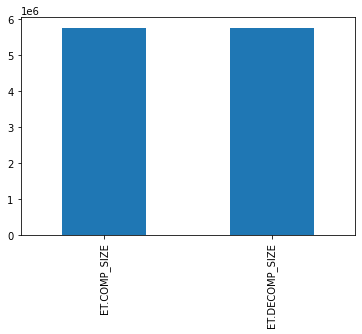

In [4]:
averages = df.iloc[-1]
sizes = averages[[ET.COMP_SIZE, ET.DECOMP_SIZE]]
sizes.plot.bar()

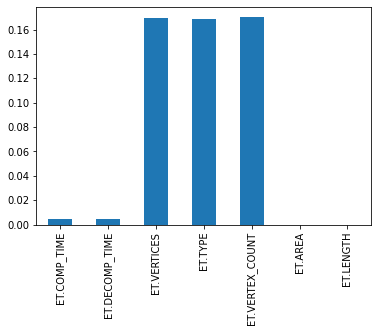

In [5]:
times = averages.drop(['idx', ET.COMP_SIZE, ET.DECOMP_SIZE])
times.plot.bar();

### Export to CSV

In [6]:
# Exports in the format: 2023-02-13_17:09:12_NoCompression.
df.to_csv("reports/" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + "_" + ALG.__class__.__name__ + ".csv")

### Verify Integrity
Need to check that the operations are correct and that the decompression is lossless.

In [7]:
# Is decompressed file equal to original?
assert(filecmp.cmp(DECOMPR_PATH, DATASET_PATH, shallow=False))

df = pd.DataFrame(vals)
old_ALG = ALG

# Validate the operations, i.e. verify that "results of the operations performed above" == "the results using no compression".
ALG = NoCompression(DATASET_PATH) # Alter global compression algorithm, used in 'measure_unary()'
for _, r in df.iterrows():
    # The operations that are checked here (supported by "measure_unary"):
    unary_operations = [ET.VERTICES, ET.TYPE, ET.VERTEX_COUNT, ET.AREA, ET.LENGTH]
    for uop in unary_operations:
        v_no_compression = measure_unary(uop, r.idx, value_only=True)
        assert(v_no_compression == r[uop])

ALG = old_ALG